In [25]:
import numpy as np
import librosa
import os
import glob
import warnings
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import SparseCoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import SparseCoder


In [29]:
# MFCC
def extract_features(audio_file, mfcc=13):
    signal, sample_rate = librosa.load(audio_file, sr=None)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=mfcc)
    return mfcc.mean(axis=1)

In [47]:
# PLP
# !pip3.8 install sidekit
from sidekit.frontend.features import plp

def extract_features(audio_file, num_ceps=13):
    signal, sample_rate = librosa.load(audio_file, sr=None)
    plp_coeffs, _ = plp(signal, fs=sample_rate, rasta=True, num_ceps=num_ceps)
    return np.mean(plp_coeffs, axis=1)

In [ ]:
def extract_features(audio_file, wavelet='db4', level=4):
    signal, sample_rate = librosa.load(audio_file, sr=None)
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = np.concatenate([np.mean(c) for c in coeffs] + [np.std(c) for c in coeffs])
    return features

In [51]:
# testing 
acc_list = []

for n_feature in range(50,100):
    acc = 0
    for k in range(3):
        
        # Load TIMIT dataset
        data_dir = 'TIMIT/data'
        train_dir = os.path.join(data_dir, 'TRAIN')

        # Select a random subset of speakers for training
        num_speakers_to_pick = 50  # Change this value to select a different number of speakers

        all_speakers = []
        dialects = os.listdir(train_dir)
        for dialect in dialects:
            if '.' not in dialect:
                speakers = os.listdir(os.path.join(train_dir, dialect))
                all_speakers.extend(speakers)

        selected_speakers = random.sample(all_speakers, num_speakers_to_pick)

#         print("Selected speakers:", selected_speakers)

        # Load dataset. Use 80% of the sentences of each speaker for training and 20% for testing
        X_train, y_train = [], []
        X_test, y_test = [], []

        dialects = os.listdir(train_dir)
        for dialect in dialects:
            if '.' not in dialect:
                speakers = os.listdir(os.path.join(train_dir, dialect))
            for speaker in speakers:
                if speaker not in selected_speakers:
                    continue
                audio_files = glob.glob(os.path.join(train_dir, dialect, speaker, '*.WAV'))
                np.random.shuffle(audio_files)
                num_sentences = len(audio_files)
                for i, audio_file in enumerate(audio_files):
                    features = extract_features(audio_file,n_feature)
                    if i < num_sentences * 0.8:
                        X_train.append(features)
                        y_train.append(speaker)
                    else:
                        X_test.append(features)
                        y_test.append(speaker)

        # Convert to numpy arrays
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_test, y_test = np.array(X_test), np.array(y_test)

        # Preprocessing
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # print('Number of speakers:', len(np.unique(y_train)))

        # Dictionary creation
        dictionary = X_train.T

        # Sparse representation
        coder = SparseCoder(dictionary.T, transform_algorithm='lasso_lars', transform_alpha=1.)

        # Classification
        y_pred = []
        for i, x in tqdm(enumerate(X_test)):
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                sparse_representation = coder.transform(x.reshape(1, -1))[0,:]

            residual = [
                np.linalg.norm(x - np.dot(dictionary[:, y_train == speaker], sparse_representation[y_train == speaker])) 
                for speaker in np.unique(y_train)
            ]
            y_pred.append(np.unique(y_train)[np.argmin(residual)])
            # print(np.min(residual), y_pred[i], y_test[i])

        # Evaluation
#         print(f"{mfcc:} Accuracy: {accuracy_score(y_test, y_pred)}")

#         print("\nClassification Report:\n", classification_report(y_test, y_pred))
        acc += accuracy_score(y_test, y_pred)
     
    print(f"{n_feature:} Accuracy: {acc/3}")
    acc_list.append((n_feature,acc/3.0))

print(acc_list)

98it [00:00, 144.33it/s]
96it [00:00, 144.67it/s]
98it [00:00, 144.63it/s]


50 Accuracy: 0.9212726757369615


98it [00:00, 145.61it/s]
98it [00:00, 145.14it/s]
98it [00:00, 147.06it/s]


51 Accuracy: 0.914965986394558


100it [00:00, 142.50it/s]
98it [00:00, 132.52it/s]
96it [00:00, 138.53it/s]


52 Accuracy: 0.9152862811791384


96it [00:00, 139.44it/s]
96it [00:00, 138.85it/s]
98it [00:00, 125.27it/s]


53 Accuracy: 0.9277210884353742


100it [00:00, 133.12it/s]
100it [00:00, 134.60it/s]
96it [00:00, 136.60it/s]


54 Accuracy: 0.8984722222222222


98it [00:00, 131.03it/s]
98it [00:00, 134.79it/s]
98it [00:00, 121.80it/s]


55 Accuracy: 0.9217687074829932


100it [00:00, 127.49it/s]
100it [00:00, 130.63it/s]
100it [00:00, 124.79it/s]


56 Accuracy: 0.9366666666666666


100it [00:00, 129.79it/s]
98it [00:00, 130.54it/s]
100it [00:00, 134.29it/s]


57 Accuracy: 0.9193197278911565


98it [00:00, 129.30it/s]
98it [00:00, 134.78it/s]
100it [00:00, 129.43it/s]


58 Accuracy: 0.9290476190476191


96it [00:00, 132.51it/s]
98it [00:00, 132.09it/s]
100it [00:00, 129.76it/s]


59 Accuracy: 0.9080640589569161


100it [00:00, 124.36it/s]
94it [00:00, 120.01it/s]
94it [00:00, 128.59it/s]


60 Accuracy: 0.9168085106382978


98it [00:00, 123.75it/s]
100it [00:00, 120.03it/s]
98it [00:00, 123.18it/s]


61 Accuracy: 0.8883673469387755


96it [00:00, 125.83it/s]
100it [00:00, 121.49it/s]
98it [00:00, 123.91it/s]


62 Accuracy: 0.9051558956916099


100it [00:00, 122.32it/s]
100it [00:00, 119.47it/s]
100it [00:00, 116.08it/s]


63 Accuracy: 0.9333333333333332


96it [00:00, 119.96it/s]
96it [00:00, 120.77it/s]
98it [00:00, 119.50it/s]


64 Accuracy: 0.9380668934240363


98it [00:00, 118.79it/s]
98it [00:00, 122.17it/s]
98it [00:00, 119.80it/s]


65 Accuracy: 0.9183673469387755


100it [00:00, 118.76it/s]
98it [00:00, 117.43it/s]
98it [00:00, 112.20it/s]


66 Accuracy: 0.8918367346938775


100it [00:00, 112.88it/s]
98it [00:00, 115.01it/s]
100it [00:00, 117.52it/s]


67 Accuracy: 0.9228571428571429


98it [00:00, 116.86it/s]
100it [00:00, 114.58it/s]
98it [00:00, 111.96it/s]


68 Accuracy: 0.8683673469387756


98it [00:00, 112.43it/s]
100it [00:00, 109.91it/s]
96it [00:00, 112.34it/s]


69 Accuracy: 0.9184126984126983


94it [00:00, 112.04it/s]
100it [00:00, 113.35it/s]
98it [00:00, 111.12it/s]


70 Accuracy: 0.8966217976552323


94it [00:00, 112.44it/s]
98it [00:00, 110.26it/s]
96it [00:00, 107.12it/s]


71 Accuracy: 0.9236638804457954


98it [00:00, 109.31it/s]
98it [00:00, 103.97it/s]
98it [00:00, 106.97it/s]


72 Accuracy: 0.9047619047619048


100it [00:00, 100.87it/s]
96it [00:00, 104.24it/s]
98it [00:00, 105.09it/s]


73 Accuracy: 0.915359977324263


98it [00:00, 103.21it/s]
98it [00:00, 100.34it/s]
96it [00:00, 103.81it/s]


74 Accuracy: 0.8971797052154195


98it [00:00, 102.89it/s]
100it [00:01, 98.99it/s]
98it [00:00, 98.38it/s]


75 Accuracy: 0.8955102040816326


98it [00:01, 97.89it/s] 
98it [00:00, 102.05it/s]
100it [00:01, 96.76it/s]


76 Accuracy: 0.9053061224489797


100it [00:01, 97.44it/s]
96it [00:01, 95.75it/s]
96it [00:00, 98.94it/s]


77 Accuracy: 0.8836111111111111


98it [00:00, 100.14it/s]
98it [00:01, 97.58it/s] 
98it [00:00, 98.42it/s]


78 Accuracy: 0.901360544217687


100it [00:01, 95.25it/s]
98it [00:01, 94.50it/s]
100it [00:01, 96.99it/s]


79 Accuracy: 0.9395238095238095


98it [00:01, 96.70it/s]
94it [00:00, 97.44it/s] 
100it [00:01, 89.61it/s]


80 Accuracy: 0.9383919525256911


98it [00:01, 94.93it/s]
100it [00:01, 90.50it/s]
98it [00:01, 91.73it/s]


81 Accuracy: 0.902108843537415


98it [00:01, 89.79it/s]
98it [00:01, 89.18it/s]
98it [00:01, 89.54it/s]


82 Accuracy: 0.9013605442176872


96it [00:01, 89.18it/s]
100it [00:01, 89.64it/s]
98it [00:01, 92.23it/s]


83 Accuracy: 0.9218849206349207


100it [00:01, 86.41it/s]
100it [00:01, 85.35it/s]
96it [00:01, 89.57it/s]


84 Accuracy: 0.9158333333333334


100it [00:01, 87.80it/s]
98it [00:01, 88.83it/s]
100it [00:01, 82.85it/s]


85 Accuracy: 0.8589795918367348


100it [00:01, 84.43it/s]
98it [00:01, 86.27it/s]
100it [00:01, 83.24it/s]


86 Accuracy: 0.9264625850340136


100it [00:01, 79.32it/s]
96it [00:01, 84.69it/s]
96it [00:01, 81.56it/s]


87 Accuracy: 0.9108333333333333


100it [00:01, 78.46it/s]
98it [00:01, 80.91it/s]
98it [00:01, 79.60it/s]


88 Accuracy: 0.8820408163265306


96it [00:01, 80.61it/s]
96it [00:01, 80.20it/s]
96it [00:01, 81.81it/s]


89 Accuracy: 0.875


96it [00:01, 82.46it/s]
100it [00:01, 78.50it/s]
100it [00:01, 83.07it/s]


90 Accuracy: 0.9020833333333335


98it [00:01, 82.66it/s]
98it [00:01, 77.07it/s]
100it [00:01, 74.78it/s]


91 Accuracy: 0.8883673469387756


96it [00:01, 76.92it/s]
100it [00:01, 77.04it/s]
98it [00:01, 79.74it/s]


92 Accuracy: 0.9186281179138321


98it [00:01, 79.77it/s]
98it [00:01, 74.81it/s]
100it [00:01, 71.38it/s]


93 Accuracy: 0.8817006802721088


100it [00:01, 72.02it/s]
98it [00:01, 74.85it/s]
92it [00:01, 77.64it/s]


94 Accuracy: 0.8862348417627922


100it [00:01, 71.61it/s]
100it [00:01, 71.69it/s]
100it [00:01, 77.02it/s]


95 Accuracy: 0.8933333333333334


100it [00:01, 72.10it/s]
98it [00:01, 70.43it/s]
98it [00:01, 72.48it/s]


96 Accuracy: 0.8448299319727891


98it [00:01, 72.75it/s]
98it [00:01, 72.16it/s]
98it [00:01, 71.82it/s]


97 Accuracy: 0.891156462585034


100it [00:01, 70.67it/s]
96it [00:01, 69.31it/s]
96it [00:01, 71.65it/s]


98 Accuracy: 0.9006944444444445


100it [00:01, 69.03it/s]
94it [00:01, 69.39it/s]
98it [00:01, 66.80it/s]

99 Accuracy: 0.8874048342741352
[(50, 0.9212726757369615), (51, 0.914965986394558), (52, 0.9152862811791384), (53, 0.9277210884353742), (54, 0.8984722222222222), (55, 0.9217687074829932), (56, 0.9366666666666666), (57, 0.9193197278911565), (58, 0.9290476190476191), (59, 0.9080640589569161), (60, 0.9168085106382978), (61, 0.8883673469387755), (62, 0.9051558956916099), (63, 0.9333333333333332), (64, 0.9380668934240363), (65, 0.9183673469387755), (66, 0.8918367346938775), (67, 0.9228571428571429), (68, 0.8683673469387756), (69, 0.9184126984126983), (70, 0.8966217976552323), (71, 0.9236638804457954), (72, 0.9047619047619048), (73, 0.915359977324263), (74, 0.8971797052154195), (75, 0.8955102040816326), (76, 0.9053061224489797), (77, 0.8836111111111111), (78, 0.901360544217687), (79, 0.9395238095238095), (80, 0.9383919525256911), (81, 0.902108843537415), (82, 0.9013605442176872), (83, 0.9218849206349207), (84, 0.9158333333333334), (85, 0.8589795918367348), (86, 0.9264625850340136), (87, 0.91

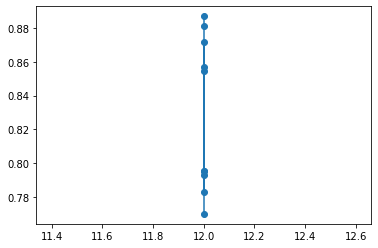

In [50]:
x,y = zip(*acc_list)
plt.plot(x,y,'o-')

In [15]:

# Dictionary creation
dictionary = X_train.T

# Sparse representation
coder = SparseCoder(dictionary.T, transform_algorithm='lasso_lars', transform_alpha=1.)

# Classification
y_pred = []
for i, x in tqdm(enumerate(X_test)):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sparse_representation = coder.transform(x.reshape(1, -1))[0,:]

    residual = [
        np.linalg.norm(x - np.dot(dictionary[:, y_train == speaker], sparse_representation[y_train == speaker])) 
        for speaker in np.unique(y_train)
    ]
    y_pred.append(np.unique(y_train)[np.argmin(residual)])
    # print(np.min(residual), y_pred[i], y_test[i])

# Evaluation
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


100it [00:00, 155.91it/s]

Accuracy: 0.90

Classification Report:
               precision    recall  f1-score   support

       FBLV0       0.67      1.00      0.80         2
       FBMJ0       1.00      0.50      0.67         2
       FDML0       1.00      1.00      1.00         2
       FEXM0       0.50      0.50      0.50         2
       FJKL0       1.00      0.50      0.67         2
       FJXP0       0.67      1.00      0.80         2
       FKAA0       1.00      1.00      1.00         2
       FMEM0       1.00      1.00      1.00         2
       FPMY0       1.00      1.00      1.00         2
       FRLL0       0.50      1.00      0.67         2
       FSBK0       1.00      1.00      1.00         2
       FTAJ0       1.00      1.00      1.00         2
       MAFM0       1.00      1.00      1.00         2
       MAKB0       0.50      1.00      0.67         2
       MARW0       1.00      1.00      1.00         2
       MBAR0       1.00      0.50      0.67         2
       MBBR0       1.00      1.00      1.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _w

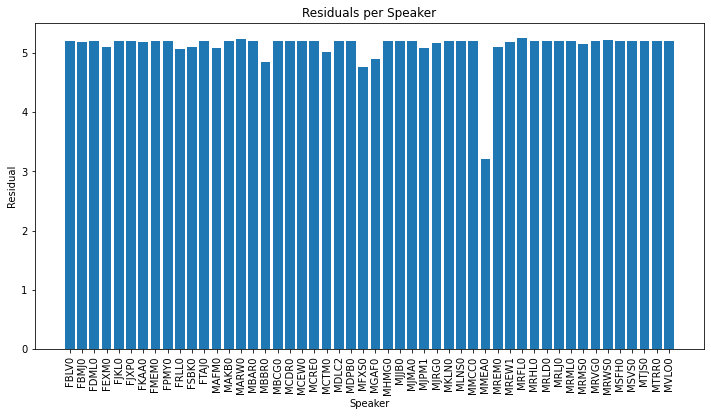

In [16]:
def plot_residuals(residuals, speakers, title='Residuals per Speaker'):
    plt.figure(figsize=(12, 6))
    plt.bar(speakers, residuals)
    plt.xlabel('Speaker')
    plt.ylabel('Residual')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()
plot_residuals(residual, np.unique(y_train))

<ipython-input-5-a7e00526c699>:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(sparse_representation, use_line_collection=True)


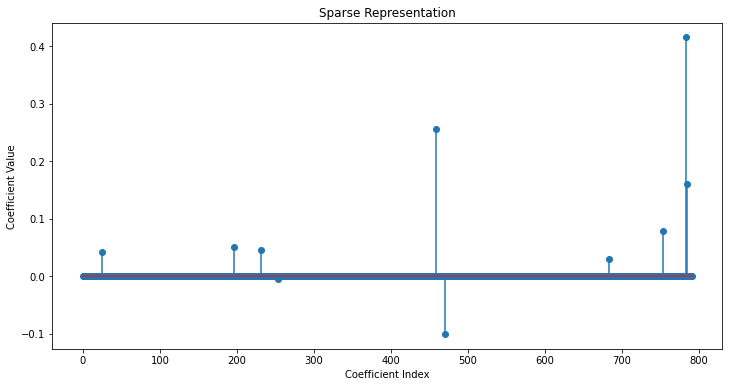

In [5]:
def plot_sparse_representation(sparse_representation, title='Sparse Representation'):
    plt.figure(figsize=(12, 6))
    plt.stem(sparse_representation, use_line_collection=True)
    plt.xlabel('Coefficient Index')
    plt.ylabel('Coefficient Value')
    plt.title(title)
    plt.show()

# Assuming you have a sparse_representation array
plot_sparse_representation(sparse_representation)